In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# xls = pd.ExcelFile('/Users/thailinhpham/Downloads/Round2.xlsx')
# data = pd.read_excel(xls, sheet_name='Purchasingdata') 
data = pd.read_csv('/Users/thailinhpham/Downloads/[RBAC 2023] Round 2 Dataset.csv')
data.head(2)

,Unnamed: 0,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,CustomerGender,VoucherStatus,Province
0,0,0,Take Away,CALL CENTER,2021-10-01 00:00:00+00:00,296891.0,1753863,Unknown,No,Ho Chi Minh City
1,1,1,Take Away,STORE,2021-10-01 00:00:00+00:00,301782.0,1124050,Unknown,No,Hanoi


In [2]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397509 entries, 0 to 1397508
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1397509 non-null  int64  
 1   BillID           1397509 non-null  int64  
 2   Channel          1397509 non-null  object 
 3   OrderFrom        1397509 non-null  object 
 4   TransactionDate  1397509 non-null  object 
 5   SalesAmount      1397509 non-null  float64
 6   CustomerID       1397509 non-null  int64  
 7   CustomerGender   1397509 non-null  object 
 8   VoucherStatus    1397509 non-null  object 
 9   Province         1397509 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 106.6+ MB
None


In [3]:
print(data.isnull().sum())

Unnamed: 0         0
BillID             0
Channel            0
OrderFrom          0
TransactionDate    0
SalesAmount        0
CustomerID         0
CustomerGender     0
VoucherStatus      0
Province           0
dtype: int64


In [4]:
data.describe()

,Unnamed: 0,BillID,SalesAmount,CustomerID
count,1.397509e+06,1.397509e+06,1.397509e+06,1.397509e+06
mean,6.987540e+05,6.987540e+05,3.103327e+05,1.087733e+06
std,4.034262e+05,4.034262e+05,3.175273e+05,6.271798e+05
min,0.000000e+00,0.000000e+00,-3.160500e+04,0.000000e+00
25%,3.493770e+05,3.493770e+05,1.780890e+05,5.463450e+05
50%,6.987540e+05,6.987540e+05,2.616930e+05,1.089029e+06
75%,1.048131e+06,1.048131e+06,3.643820e+05,1.629751e+06
max,1.397508e+06,1.397508e+06,5.773168e+07,2.174083e+06


In [5]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])  # converting the column to datetime

In [6]:
snapshot_date = data['TransactionDate'].max() + pd.DateOffset(days=1)

# Group by CustomerID
rfm_data = data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,   # Recency: the difference in days
    'BillID': 'count',     # Frequency 
    'SalesAmount':'sum'     # Monetary
})

rfm_data.rename(columns = {'TransactionDate': 'Recency',
                           'BillID': 'Frequency',
                           'SalesAmount': 'Monetary Value'}, inplace=True)

# To meet condition - segment the result into quantiles
quantiles = rfm_data.quantile(q=[0.2,0.4,0.6,0.8]) 

In [7]:
def RScore(x,p,q):   # assigning less score to Higher Recency 
    if x<=q[p][.2]:
        return 1
    elif x<=q[p][.4]:
        return 2
    elif x<=q[p][.6]: 
        return 3
    elif x<=q[p][.8]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,q): # assigning more score to Higher Frequency and Monetary values.
    if x<=q[p][.2]:
        return 1
    elif x<=q[p][.4]:
        return 2
    elif x<=q[p][.6]: 
        return 3
    elif x<=q[p][.8]: 
        return 4
    else:
        return 5
    
rfm_segmentation = rfm_data
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency', quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary Value'].apply(FMScore, args=('Monetary Value', quantiles,))

rfm_segmentation.head(2)

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
0,555,1,411663.0,5,1,4
1,482,1,105503.0,4,1,1


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_23426/2757000153.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='R_Quartile', data=rfm_segmentation, palette='cool')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_23426/2757000153.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='F_Quartile', data=rfm_segmentation, palette='cool')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_23426/2757000153.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='M_Quartile', data=rfm_segmentation, palet

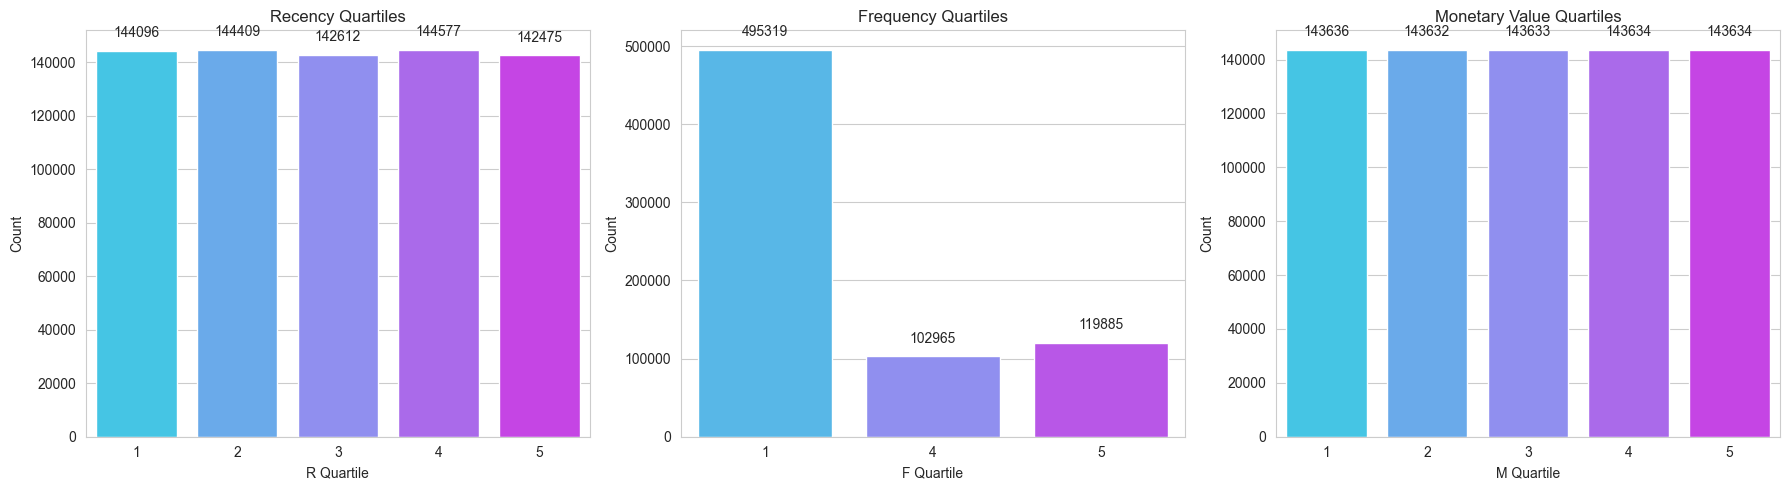

In [8]:
# Set the style for seaborn
sns.set_style('whitegrid')

# Define the size of the overall figure
plt.figure(figsize=(18, 5))

# Create the plots for Recency, Frequency, and Monetary plots
# and also store the axes in variables for further use
ax_r = plt.subplot(1, 3, 1) # Recency
sns.countplot(x='R_Quartile', data=rfm_segmentation, palette='cool')
ax_r.set_title('Recency Quartiles')
ax_r.set_xlabel('R Quartile')
ax_r.set_ylabel('Count')

ax_f = plt.subplot(1, 3, 2) # Frequency
sns.countplot(x='F_Quartile', data=rfm_segmentation, palette='cool')
ax_f.set_title('Frequency Quartiles')
ax_f.set_xlabel('F Quartile')
ax_f.set_ylabel('Count')

ax_m = plt.subplot(1, 3, 3) # Monetary
sns.countplot(x='M_Quartile', data=rfm_segmentation, palette='cool')
ax_m.set_title('Monetary Value Quartiles')
ax_m.set_xlabel('M Quartile')
ax_m.set_ylabel('Count')

# Define a function to annotate the axes with the sum of each quartile
def annotate_axes_with_sums(ax):
    # Loop through each patch (bar) in the plot
    for p in ax.patches:
        # Calculate count (height of each bar) plus some offset (like 1% of maximum patch height)
        # This will be used for positioning the text above the bar
        offset = max([patch.get_height() for patch in ax.patches]) * 0.01
        height = p.get_height() + offset
        # Annotate with the count
        ax.annotate('{}'.format(int(p.get_height())),  # Convert float to int for display
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 10),  # 10 points vertical offset
                    textcoords='offset points')

# Annotate each of the axes with the sum of customers in each quartile
annotate_axes_with_sums(ax_r)
annotate_axes_with_sums(ax_f)
annotate_axes_with_sums(ax_m)

# Display the plots in a tight layout
plt.tight_layout()
plt.show()

In [9]:
# make RFM_Score
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Quartile.map(str) + rfm_segmentation.F_Quartile.map(str) + rfm_segmentation.M_Quartile.map(str)
print(rfm_segmentation.sort_values(by=['RFM_Score', 'Monetary Value'], ascending=[True, False]))

            Recency  Frequency  Monetary Value  R_Quartile  F_Quartile  \
CustomerID                                                               
1544904         102          1        177878.0           1           1   
77831            78          1        177874.0           1           1   
681025           24          1        177871.0           1           1   
1516622          80          1        177865.0           1           1   
310353           91          1        177854.0           1           1   
...             ...        ...             ...         ...         ...   
484384          527          3        736282.0           5           5   
694549          596          3        736212.0           5           5   
1882385         531          3        736036.0           5           5   
1461272         568          3        735742.0           5           5   
1654292         507          3        735678.0           5           5   

            M_Quartile RFM_Score  
Cu

In [10]:
rfm_data['RFM_Score'].unique()

array(['514', '411', '245', '113', '313', '513', '252', '213', '412',
       '443', '345', '344', '144', '214', '511', '155', '414', '145',
       '244', '255', '555', '512', '413', '114', '444', '544', '243',
       '314', '312', '211', '355', '154', '112', '212', '111', '415',
       '311', '143', '515', '455', '454', '315', '445', '442', '254',
       '553', '354', '215', '115', '543', '142', '343', '342', '545',
       '441', '141', '253', '242', '352', '353', '542', '541', '341',
       '554', '241', '453', '151', '153', '452', '351', '152', '451',
       '251', '552', '551'], dtype=object)

In [11]:
rfm_data_test1 = rfm_data.copy()

# Convert RFM_Score to numeric for sorting purposes
rfm_data_test1['RFM_Score'] = pd.to_numeric(rfm_data_test1['RFM_Score'])

here is RFM framework for segmentation:
<img src="Pasted Graphic 1.PNG"/>

In [12]:
# Create a copy of 'rfm_data_test1' named 'rfm_data_with_segment'
rfm_data_with_segment = rfm_data_test1.copy()

# Define the segments and corresponding scores
segments = {
    'Champions': ['555', '554', '544', '545', '454', '455', '445'],
    'Loyal': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalists': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About To Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'Cannot Lose Them But Losing': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
    'Hibernating Customers': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Losing But Engaged': ['111', '112', '121', '131', '141', '151'],
    'Lost Customers': ['111', '112', '121', '131', '141', '151']
}

# use this framework: https://documentation.bloomreach.com/engagement/docs/rfm-segmentation

# Add a new column 'Segment' to 'rfm_data_with_segment' based on 'RFM_Score'
rfm_data_with_segment['Segment'] = ''
for segment, scores in segments.items():
    rfm_data_with_segment.loc[rfm_data_with_segment['RFM_Score'].astype(str).str.strip().isin(scores), 'Segment'] = segment

rfm_data_with_segment.head(1)

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile,RFM_Score,Segment
CustomerID,,,,,,,,
0,555,1,411663.0,5,1,4,514,Promising


In [13]:
segment_counts = rfm_data_with_segment['Segment'].value_counts()
total_segment_counts = len(data['CustomerID'].unique()) # or: total_population = segment_counts.sum() - same result - we tested
segment_percent = (segment_counts / total_segment_counts * 100).round(2)

print(segment_counts)
print('total segment:', total_segment_counts)

Segment
New Customers                  165567
Promising                      148352
Cannot Lose Them But Losing    113897
At Risk                         67566
Loyal                           51371
About To Sleep                  49474
Hibernating Customers           48860
Lost Customers                  36834
Champions                       25019
Need Attention                   6057
Potential Loyalists              5172
Name: count, dtype: int64
total segment: 718169


In [14]:
rfm_data_with_percentageSegment = pd.DataFrame({
    'Segment': segment_counts.index,
    'Count': segment_counts.values,
    'Percent': segment_percent.values
})

print(rfm_data_with_percentageSegment)

                        Segment   Count  Percent
0                 New Customers  165567    23.05
1                     Promising  148352    20.66
2   Cannot Lose Them But Losing  113897    15.86
3                       At Risk   67566     9.41
4                         Loyal   51371     7.15
5                About To Sleep   49474     6.89
6         Hibernating Customers   48860     6.80
7                Lost Customers   36834     5.13
8                     Champions   25019     3.48
9                Need Attention    6057     0.84
10          Potential Loyalists    5172     0.72


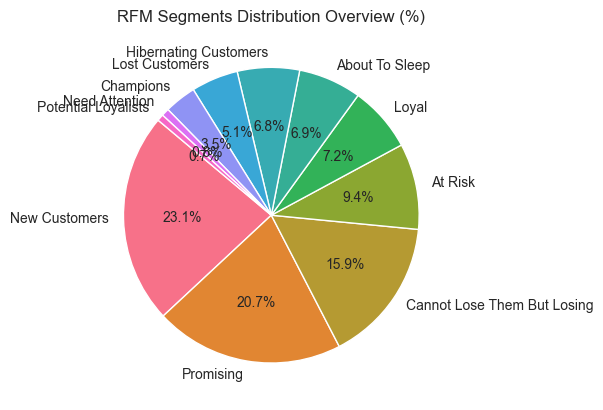

In [15]:
import seaborn as sns
plt.axis('equal') 

plt.pie(rfm_data_with_percentageSegment['Percent'], labels = rfm_data_with_percentageSegment['Segment'], autopct='%1.1f%%', startangle=140, colors = sns.color_palette("husl", 11))

plt.title('RFM Segments Distribution Overview (%)')
plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_23426/3509822386.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


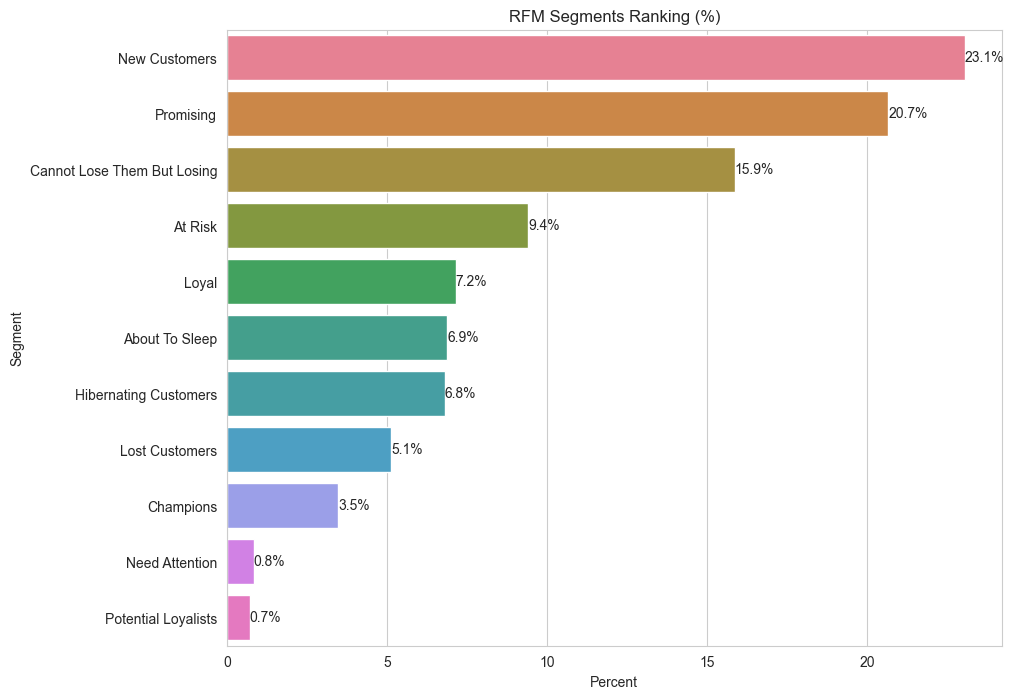

In [16]:
colors = sns.color_palette("husl", len(rfm_data_with_percentageSegment))

# Create a horizontal bar plot using seaborn
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x='Percent', 
    y='Segment', 
    data=rfm_data_with_percentageSegment, 
    palette=colors
)

plt.title('RFM Segments Ranking (%)')
plt.xlabel('Percent')
plt.ylabel('Segment')

# Add number value to each bar
for p in ax.patches:
    # Getting the x and y position for each annotation
    # Since it's a horizontal bar chart, the "height" prop gives the bar length (width in horizontal chart)
    x_value = p.get_width()
    y_value = p.get_y() + p.get_height() / 2
    
    # Using x_value for the annotation and positioning it slightly outside the bar end
    ax.annotate(f'{x_value:.1f}%', (x_value, y_value), ha='left', va='center')

plt.show()

In [17]:
data_with_rfm = pd.merge(data, rfm_data_with_segment, on='CustomerID')

In [18]:
# export data for visualization via PowerBI
data_with_rfm.to_csv("data_with_rfm.csv")

In [19]:
data_with_rfm_churned = data_with_rfm.copy()

In [20]:
# Define churn based on the 'Recency' feature
threshold_days = 180  # Define the churn threshold
data_with_rfm_churned['Churn'] = (data_with_rfm_churned['Recency'] > threshold_days).astype(int)

In [21]:
from sklearn.model_selection import train_test_split

# Define your features and label
features = ['Recency', 'Frequency', 'Monetary Value', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFM_Score']
X = data_with_rfm_churned[features]
y = data_with_rfm_churned['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Fit the model
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Make predictions
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142372
           1       1.00      1.00      1.00    137130

    accuracy                           1.00    279502
   macro avg       1.00      1.00      1.00    279502
weighted avg       1.00      1.00      1.00    279502

[[142372      0]
 [     0 137130]]


In [25]:
data_with_rfm_churned['ChurnProbability'] = None
data_with_rfm_churned.loc[y_test.index, 'ChurnProbability'] = y_pred_proba

In [26]:
rfm_data_with_segment_test = rfm_data_with_segment.copy()
rfm_data_with_segment_test.head(1)

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile,RFM_Score,Segment
CustomerID,,,,,,,,
0,555,1,411663.0,5,1,4,514,Promising


In [27]:
rfm_data_with_segment_test = rfm_data_with_segment_test[rfm_data_with_segment_test['Segment']=='Loyal']
rfm_data_with_segment_test

,Recency,Frequency,Monetary Value,R_Quartile,F_Quartile,M_Quartile,RFM_Score,Segment
CustomerID,,,,,,,,
38,321,2,740710.0,3,4,5,345,Loyal
43,331,2,717485.0,3,4,4,344,Loyal
93,415,2,682995.0,4,4,4,444,Loyal
97,329,2,498285.0,3,4,4,344,Loyal
128,253,2,685562.0,3,4,4,344,Loyal
...,...,...,...,...,...,...,...,...
2173817,314,2,580896.0,3,4,4,344,Loyal
2173875,247,12,4040018.0,3,5,5,355,Loyal
2173994,359,2,564977.0,3,4,4,344,Loyal


In [28]:
# Ensure 'TransactionDate' is a datetime type
data_with_rfm_churned['TransactionDate'] = pd.to_datetime(data_with_rfm_churned['TransactionDate'])

# Optionally define a churn lag, for example, if a customer is considered churned 30 days after last transaction
churn_lag = pd.Timedelta(days=60)

# Assume customers who have churned have a 'TransactionDate' which is the last date of purchase
# and we add churn lag to consider the churn event date
data_with_rfm_churned['ChurnDate'] = data_with_rfm_churned['TransactionDate'] + churn_lag * data_with_rfm_churned['Churn']

# Now group only the churned customers by 'ChurnDate' to count weekly churns
weekly_churn = data_with_rfm_churned[data_with_rfm_churned['Churn'] == 1].groupby(pd.Grouper(key='ChurnDate', freq='W')).size()

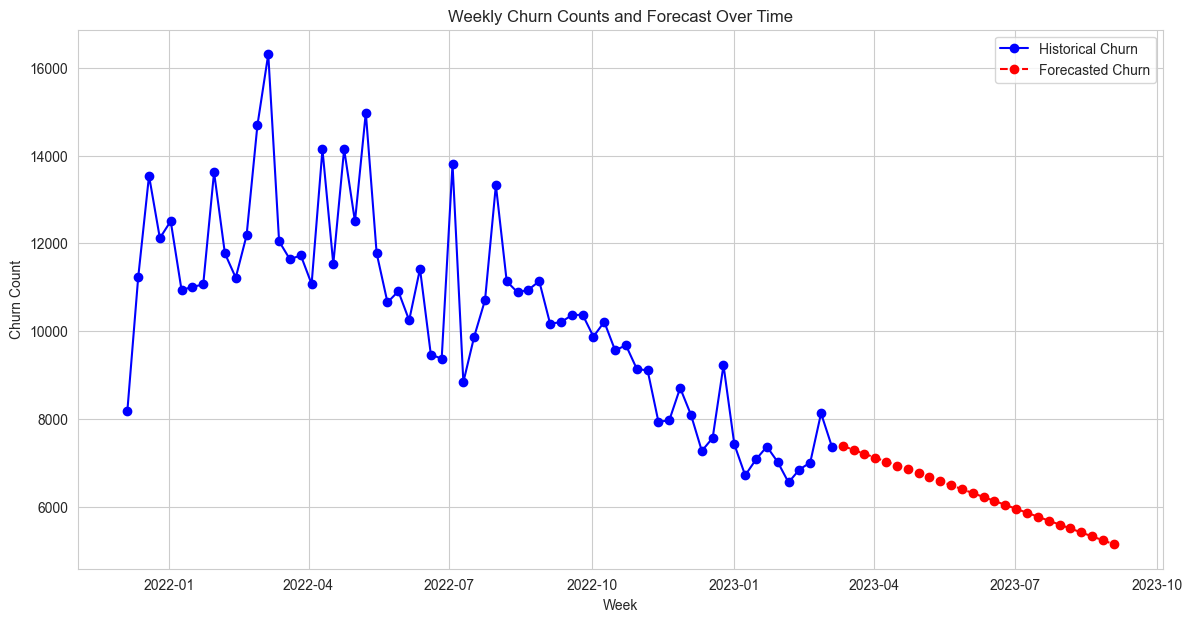

In [29]:
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import DateOffset

# Create a DataFrame from the series for modeling purposes
churn_df = weekly_churn.reset_index(name='ChurnCount')

# Create an integer index for weeks to use with scikit-learn, which doesn't accept datetime for X
churn_df['WeekIndex'] = list(range(len(churn_df)))

# Instantiate and fit the linear regression model
model = LinearRegression()
model.fit(churn_df[['WeekIndex']], churn_df['ChurnCount'])

# Predict the next 6 months (approx. 26 weeks)
future_weeks = 26
last_week_index = churn_df['WeekIndex'].iloc[-1]
future_indices = pd.DataFrame({'WeekIndex': range(last_week_index + 1, last_week_index + 1 + future_weeks)})
future_churn = model.predict(future_indices)

# Add the future week dates to the future_indices DataFrame
# The '+1' below ensures it starts from the week right after the last week in the historical data
future_indices['ChurnDate'] = pd.date_range(start=churn_df['ChurnDate'].iloc[-1] + DateOffset(weeks=1), periods=future_weeks, freq='W')

# Plot the historical churn alongside the forecast
plt.figure(figsize=(14, 7))
plt.plot(churn_df['ChurnDate'], churn_df['ChurnCount'], marker='o', color='blue', label='Historical Churn')
plt.plot(future_indices['ChurnDate'], future_churn, marker='o', color='red', linestyle='--', label='Forecasted Churn')

plt.title('Weekly Churn Counts and Forecast Over Time')
plt.xlabel('Week')
plt.ylabel('Churn Count')
plt.grid(True)
plt.legend()
plt.show()

### the code will be stored at this link below:
https://github.com/Japricity/rbac4
